# Testing data retrieval from [The Batch](https://www.deeplearning.ai/the-batch/tag/deeplearning-ai-news/) AI news and insigths

In [3]:
import json
import time
import re
import requests
import torch
import transformers
import open_clip

from __future__ import annotations
from typing import List, Optional
from transformers import pipeline

from pydantic import BaseModel, HttpUrl
from bs4 import BeautifulSoup



from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

from bs4 import BeautifulSoup
from pydantic import HttpUrl

from PIL import Image

/Users/admin/Desktop/MyProjects/Multimodal-RAG-System/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class ImageMeta(BaseModel):
    image_id: str
    url: str
    local_path: Optional[str] = None
    alt: Optional[str] = None


class Article(BaseModel):
    article_id: str
    title: str
    url: str
    primary_topic: str
    topic_label: Optional[str] = None
    tags: List[str] = []
    published_at: Optional[datetime] = None
    body_text: str
    images: List[ImageMeta] = []

In [5]:
def clean_html_fragment_to_text(html_fragment: str) -> str:
    """
    Cleans HTML into a plain text.
    """
    if not html_fragment:
        return ""

    soup = BeautifulSoup(html_fragment, "html.parser")

    for tag in soup(["script", "style"]):
        tag.decompose()

    text = soup.get_text(separator="\n")
    
    text = re.sub(r"\r\n", "\n", text)
    text = re.sub(r"[ \t]+", " ", text)
    text = re.sub(r"\n{2,}", "\n\n", text)
    text = text.strip()

    return text

In [6]:
BASE_ARTICLE_URL = "https://www.deeplearning.ai/the-batch"


TOPICS: Dict[str, Dict[str, str]] = {
    "letters": {
        "slug": "letters",
        "label": "Andrew's Letters",
    },
    "data-points": {
        "slug": "data-points",
        "label": "Data Points",
    },
    "research": {
        "slug": "research",
        "label": "ML Research",
    },
    "business": {
        "slug": "business",
        "label": "Business",
    },
    "science": {
        "slug": "science",
        "label": "Science",
    },
    "culture": {
        "slug": "culture",
        "label": "Culture",
    },
    "hardware": {
        "slug": "hardware",
        "label": "Hardware",
    },
}

In [19]:
class TheBatchIngestor:
    """
    Ingests articles from https://www.deeplearning.ai/the-batch/ for specific topics.

    For each topic:
      - Fetch https://www.deeplearning.ai/the-batch/tag/{slug}/
      - Parse __NEXT_DATA__ to get 'posts' list (cards on the page)
      - For each post, fetch the article page /the-batch/{article_name}/
        and parse 'post.html' from __NEXT_DATA__ for full text.
    """

    def __init__(self, session: Optional[requests.Session] = None, delay_seconds: float = 1.0):
        self.session = session or requests.Session()
        self.delay_seconds = delay_seconds

        self.session.headers.update(
            {
                "User-Agent": (
                    "Mozilla/5.0 (compatible; TheBatchRAGBot/0.1 (+https://github.com/Fenix125/Multimodal-RAG-System)"
                ),
                "Accept-Language": "en-US,en;q=0.9",
            }
        )

    def clean_body_text(self, body_html: str) -> str:
        """
        Convert article HTML into clean plain text:
        - strip scripts/styles (handled by clean_html_fragment_to_text)
        - remove ElevenLabs audio intro if present
        - flatten single newlines inside paragraphs to spaces
          while preserving paragraph breaks (double newlines).
        """
        AUDIO_INTRO_RE = re.compile(
            r"^Loading the\s+Elevenlabs Text to Speech\s+AudioNative Player\.\.\.\s*",
            flags=re.IGNORECASE | re.MULTILINE,
        )

        text = clean_html_fragment_to_text(body_html)

        text = re.sub(AUDIO_INTRO_RE, "", text, count=1).lstrip()

        paragraphs = text.split("\n\n")

        cleaned_paragraphs = []
        for p in paragraphs:
            p = p.strip()
            if not p:
                continue
            p = re.sub(r"\s*\n\s*", " ", p)
            cleaned_paragraphs.append(p)

        return "\n\n".join(cleaned_paragraphs)
    
    def ingest_all_topics(self, topics: Optional[Iterable[str]] = None, output_jsonl: Optional[Path] = None) -> List[Article]:
        """
        Ingest articles for the selected topics from deeplearning.ai/the-batch.

        topics: list of topic keys (If None, uses all keys defined in TOPICS)
        """
        if topics is None:
            topics = TOPICS.keys()

        articles_by_slug: Dict[str, Article] = {}

        for topic_key in topics:
            if topic_key not in TOPICS:
                print(f"[WARN] Unknown topic key '{topic_key}', skipping.")
                continue

            topic_info = TOPICS[topic_key]
            tag_slug = topic_info["slug"]
            topic_label = topic_info["label"]

            print(f"[INFO] Ingesting topic '{topic_label}', tag='{tag_slug}')")

            posts = self.fetch_posts_for_tag(tag_slug)
            print(f"[INFO]   Tag '{tag_slug}': found {len(posts)} posts on article page.")

            for post_meta in posts:
                slug = post_meta.get("slug")
                if not slug:
                    continue

                if slug in articles_by_slug:
                    existing = articles_by_slug[slug]
                    if topic_key not in existing.tags:
                        existing.tags.append(topic_key)
                    continue

                try:
                    article = self.build_article_from_post_meta(
                        topic_key=topic_key,
                        topic_label=topic_label,
                        post_meta=post_meta,
                    )
                    articles_by_slug[slug] = article
                except Exception as e:
                    print(f"[ERROR] Failed to build article for slug '{slug}': {e}")

        articles = list(articles_by_slug.values())
        articles.sort(key=lambda a: (a.published_at or datetime.min), reverse=True)

        if output_jsonl is not None:
            output_jsonl.parent.mkdir(parents=True, exist_ok=True)
            with output_jsonl.open("w", encoding="utf-8") as f:
                for art in articles:
                    f.write(art.model_dump_json() + "\n")
            print(f"[INFO] Saved {len(articles)} articles to {output_jsonl}")

        print(f"[DONE] Ingested {len(articles)} unique articles in total.")
        return articles

    def tag_page_url(self, tag_slug: str) -> str:
        """
        For each topic, we use the front-end tag page:

        https://www.deeplearning.ai/the-batch/tag/{slug}/
        """
        return f"{BASE_ARTICLE_URL}/tag/{tag_slug}/"

    def fetch_posts_for_tag(self, tag_slug: str) -> List[dict]:
        """
        Fetch posts list for a given tag from /the-batch/tag/{slug}/.

        Already contains a list of article cards for the topic in __NEXT_DATA__
        """
        url = self.tag_page_url(tag_slug)
        html = self.get(url)
        if not html:
            print(f"[WARN] Empty or failed tag page for tag='{tag_slug}'.")
            return []

        next_data = self.extract_next_data(html)
        posts = self.extract_posts_from_tag_next_data(next_data)
        return posts

    def build_article_from_post_meta(self, topic_key: str, topic_label: str, post_meta: dict) -> Article:
        slug = post_meta["slug"]
        article_url = f"{BASE_ARTICLE_URL}/{slug}/"

        print(f"[INFO]   Fetching article '{slug}' -> {article_url}")
        html = self.get(article_url)
        if not html:
            raise RuntimeError(f"Empty HTML for article '{slug}'")

        next_data = self.extract_next_data(html)
        post_obj = self.extract_post_from_article_next_data(next_data)

        full_title = (post_meta.get("title") or "").strip()

        custom_excerpt = (post_meta.get("custom_excerpt") or "").strip()
        excerpt = (post_meta.get("excerpt") or "").strip()

        body_html = post_obj.get("html") or ""
        body_text = self.clean_body_text(body_html)

        published_at = None
        published_raw = post_obj.get("published_at")
        if published_raw:
            try:
                published_at = datetime.fromisoformat(
                    published_raw.replace("Z", "+00:00")
                )
            except ValueError:
                pass

        tags = [t.get("name") for t in (post_meta.get("tags") or []) if t.get("name")]

        feature_image = post_meta.get("feature_image")
        feature_image_alt = post_meta.get("feature_image_alt") or None

        images: List[ImageMeta] = []
        if feature_image:
            image_id = f"{slug}_hero"
            images.append(
                ImageMeta(
                    image_id=image_id,
                    url=feature_image,
                    local_path=None,
                    alt=feature_image_alt
                )
            )

        article = Article(
            article_id=slug,
            title=full_title,
            url=article_url,
            primary_topic=topic_key,
            topic_label=topic_label,
            tags=tags,
            published_at=published_at,
            body_text=body_text,
            images=images,
        )

        return article

    def get(self, url: str) -> Optional[str]:
        try:
            resp = self.session.get(url, timeout=20)
            if resp.status_code != 200:
                print(f"[WARN] GET {url} -> {resp.status_code}")
                return None
            time.sleep(self.delay_seconds)
            return resp.text
        except requests.RequestException as e:
            print(f"[ERROR] Request failed for {url}: {e}")
            return None

    def extract_next_data(self, html: str) -> dict:
        """
        Extract Next.js __NEXT_DATA__ JSON from an HTML page.
        """
        soup = BeautifulSoup(html, "html.parser")
        script = soup.find("script", id="__NEXT_DATA__", type="application/json")
        if not script or not script.string:
            raise RuntimeError("Could not find __NEXT_DATA__ script tag")
        try:
            data = json.loads(script.string)
        except json.JSONDecodeError as e:
            raise RuntimeError(f"Failed to parse __NEXT_DATA__ JSON: {e}") from e
        return data

    def extract_posts_from_tag_next_data(self, next_data: dict) -> List[dict]:
        """
        On tag pages, posts are at next_data['props']['pageProps']['posts'].
        """
        props = next_data.get("props", {})
        page_props = props.get("pageProps", {})
        posts = page_props.get("posts") or []
        if not isinstance(posts, list):
            return []
        return posts

    def extract_post_from_article_next_data(self, next_data: dict) -> dict:
        """
        On article pages, the full article is in next_data['props']['pageProps']['post'].
        """
        props = next_data.get("props", {})
        page_props = props.get("pageProps", {})
        post = page_props.get("post")
        if not isinstance(post, dict):
            raise RuntimeError("No 'post' object found in article __NEXT_DATA__")
        return post

In [20]:
ingestor = TheBatchIngestor()

output_path = Path("data/processed/the_batch_articles.jsonl")
output_path.parent.mkdir(parents=True, exist_ok=True)

topics = [
    "letters",
    "data-points",
    # "research",
    # "business",
    # "science",
    # "culture",
    # "hardware",
]

articles = ingestor.ingest_all_topics(
    topics=topics,
    output_jsonl=output_path,
)

print(f"[DONE] Total articles saved: {len(articles)}")


[INFO] Ingesting topic 'Andrew's Letters', tag='letters')
[INFO]   Tag 'letters': found 15 posts on article page.
[INFO]   Fetching article 'a-robot-holds-a-bubble-wand-surrounded-by-bubbles-and-colorful-trees-with-a-futuristic-city-skyline' -> https://www.deeplearning.ai/the-batch/a-robot-holds-a-bubble-wand-surrounded-by-bubbles-and-colorful-trees-with-a-futuristic-city-skyline/
[INFO]   Fetching article 'what-we-learned-at-ai-dev-x-nyc-2025' -> https://www.deeplearning.ai/the-batch/what-we-learned-at-ai-dev-x-nyc-2025/
[INFO]   Fetching article 'dont-believe-the-hype' -> https://www.deeplearning.ai/the-batch/dont-believe-the-hype/
[INFO]   Fetching article 'tear-down-data-silos' -> https://www.deeplearning.ai/the-batch/tear-down-data-silos/
[INFO]   Fetching article 'announcing-the-deeplearning-ai-pro-membership' -> https://www.deeplearning.ai/the-batch/announcing-the-deeplearning-ai-pro-membership/
[INFO]   Fetching article 'improve-agentic-performance-with-evals-and-error-analysis

In [21]:
articles = []
with open("data/processed/the_batch_articles.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        articles.append(json.loads(line))

articles[0]

{'article_id': 'opus-4-5-drops-prices-reclaims-coding-crown',
 'title': 'Opus 4.5 drops prices, reclaims coding crown: DeepSeek’s new open-weights math model claims IMO Gold',
 'url': 'https://www.deeplearning.ai/the-batch/opus-4-5-drops-prices-reclaims-coding-crown/',
 'primary_topic': 'data-points',
 'topic_label': 'Data Points',
 'tags': ['Data Points'],
 'published_at': '2025-11-28T09:22:00-08:00',
 'body_text': 'Welcome back! In today’s edition of Data Points, you’ll learn more about: FLUX.2, a Nano Banana-class open image generator OpenAI’s third-party web analytics security breach Genesis Mission, a new U.S. government resource sharing program Suno’s latest deal with music giant Warner But first: Claude Opus 4.5 achieves SOTA coding and agent capabilities Anthropic launched Claude Opus 4.5, positioning it as the leading model for software engineering, autonomous agents, and computer use. The model leads on seven out of eight programming languages on SWE-bench Multilingual and sc

In [22]:
articles[1]

{'article_id': 'a-robot-holds-a-bubble-wand-surrounded-by-bubbles-and-colorful-trees-with-a-futuristic-city-skyline',
 'title': 'Understanding the AI Bubble — If There Is One',
 'url': 'https://www.deeplearning.ai/the-batch/a-robot-holds-a-bubble-wand-surrounded-by-bubbles-and-colorful-trees-with-a-futuristic-city-skyline/',
 'primary_topic': 'letters',
 'topic_label': "Andrew's Letters",
 'tags': ['Letters', 'Nov 26, 2025'],
 'published_at': '2025-11-26T13:23:50-08:00',
 'body_text': "Dear friends, Is there an AI bubble? With the massive number of dollars going into AI infrastructure such as OpenAI’s $1.4 trillion plan and Nvidia briefly reaching a $5 trillion market cap, many have asked if speculation and hype have driven the values of AI investments above sustainable values. However, AI isn’t monolithic, and different areas look bubbly to different degrees. AI application layer: There is underinvestment. The potential is still much greater than most realize. AI infrastructure for in

example of retirieved article with it's metadata:

```markdown
{
  "article_id": "opus-4-5-drops-prices-reclaims-coding-crown",
  "title": "Opus 4.5 drops prices, reclaims coding crown: DeepSeek’s new open-weights math model claims IMO Gold",
  "url": "https://www.deeplearning.ai/the-batch/opus-4-5-drops-prices-reclaims-coding-crown/",
  "primary_topic": "data-points",
  "topic_label": "Data Points",
  "tags": [
    "Data Points"
  ],
  "published_at": "2025-11-28T09:22:00-08:00",
  "body_text": "Welcome back! In today’s edition of Data Points, you’ll learn more about: FLUX.2, a Nano Banana-class open image generator OpenAI’s third-party web analytics security breach Genesis Mission, a new U.S. government resource sharing program Suno’s latest deal with music giant Warner But first: Claude Opus 4.5 achieves SOTA coding and agent capabilities Anthropic launched Claude Opus 4.5, positioning it as the leading model for software engineering, autonomous agents, and computer use. The model leads on seven out of eight programming languages on SWE-bench Multilingual and scored higher than any human candidate on Anthropic’s internal performance engineering exam within a two-hour time limit. The release includes a new effort parameter that lets developers control token usage; at medium effort, Opus 4.5 matches Sonnet 4.5’s performance while using 76 percent fewer output tokens. Opus 4.5 is available now through Claude apps, API, and major cloud platforms at five dollars per million input tokens and 25 dollars per million output tokens. ( Anthropic ) DeepSeekMath-V2 claims International Mathematics Olympiad Gold DeepSeek introduced DeepSeekMath-V2, a language model that verifies the correctness of its own mathematical reasoning step-by-step rather than relying solely on final answer accuracy. The model achieved gold-level scores on IMO 2025 and CMO 2024 competitions and scored 118 out of 120 on Putnam 2024 when using scaled test-time compute. The system trains a verifier to check theorem proofs for comprehensiveness and rigor, then uses that verifier as a reward model to train a proof generator that identifies and fixes issues in its own work before finalizing solutions. The approach addresses limitations in current reinforcement learning methods that reward correct final answers but can’t verify reasoning quality or handle tasks like theorem proving, which require rigorous derivation without numerical answers. The model’s weights are available freely on GitHub. ( GitHub ) Black Forest Labs launches FLUX.2 with multi-reference editing Black Forest Labs’ image generation model FLUX.2 handles up to 10 reference images simultaneously while maintaining character and style consistency, and edits images at resolutions up to 4 megapixels. The model combines a Mistral-3 24-billion-parameter vision-language model with a rectified flow transformer, improving text rendering, prompt adherence, and photorealism over FLUX.1. The company released four variants: FLUX.2 [pro] and [flex] as managed APIs, FLUX.2 [dev] as a 32-billion-parameter open-weight model available on Hugging Face under a non-commercial license, and FLUX.2 [klein] coming soon as an Apache 2.0 licensed model. The FLUX.2 VAE is available now under Apache 2.0 license, with API access through partners including FAL, Replicate, Runware, TogetherAI, Cloudflare, and DeepInfra. ( Black Forest Labs ) OpenAI discloses security incident at external analytics provider A breach at Mixpanel, a web analytics service OpenAI used for its API platform, exposed user profile data for some API customers. The November 9 incident affected names, email addresses, coarse location data, browser information, and organization IDs associated with platform.openai.com accounts. No chat content, API requests, passwords, API keys, payment information, or government IDs were compromised. OpenAI terminated its contract with Mixpanel and is conducting expanded security reviews across its vendor ecosystem. The company recommends users stay alert for phishing attempts using the exposed profile information and enable multi-factor authentication as a precaution. ( OpenAI ) White House “Genesis” to lend government data to AI companies U.S. President Donald Trump signed an executive order directing the Department of Energy and national labs to build a digital platform consolidating federal scientific data for AI analysis. The Genesis Mission solicits tech companies and universities to apply their AI systems to government challenges in engineering, energy, and national security, including optimizing the electric grid. The administration compared the effort to the Apollo program, though it follows billions in cuts to federal research funding and thousands of job losses among government scientists. Funding comes from the tax and spending bill Trump signed in July, with the project using both national lab supercomputers and private sector computing capacity. ( Associated Press ) Suno partners with Warner to train AI models on licensed catalog Suno signed a deal with Warner Music Group to build new AI music generation models trained on WMG’s licensed recordings. The partnership will introduce features letting fans create music using the voices and likenesses of participating WMG artists, with those artists receiving compensation. Suno will require a paid subscription to download generated songs, though its Studio product will retain unlimited downloads. The company said its core music creation experience will remain unchanged while it develops what it calls a new generation of models that will surpass its current v5 system. Warner Music and Suno also settled their copyright lawsuit; similar cases against Suno by Universal and Sony continue. ( Suno ) A special offer for our community DeepLearning.AI recently launched the first-ever subscription plan for our entire course catalog! As a Pro Member, you’ll immediately enjoy access to: Over 150 AI courses and specializations from Andrew Ng and industry experts Labs and quizzes to test your knowledge Projects to share with employers Certificates to testify to your new skills A community to help you advance at the speed of AI Enroll now to lock in a year of full access for $25 per month paid upfront, or opt for month-to-month payments at just $30 per month. Both payment options begin with a one week free trial. Explore Pro’s benefits and start building today! Try Pro Membership Still want to know more about what matters in AI right now? Read this week’s issue of The Batch for in-depth analysis of news and research. This week, Andrew Ng talked about the potential AI bubble, highlighting underinvestment in AI applications, the need for more AI infrastructure for inference, and the risks associated with AI infrastructure for model training. “I remain bullish about AI investments broadly. But what is the downside scenario — that is, is there a bubble that will pop? One scenario that worries me: If part of the AI stack (perhaps in training infra) suffers from overinvestment and collapses, it could lead to negative market sentiment around AI more broadly and an irrational outflow of interest away from investing in AI, despite the field overall having strong fundamentals.” Read Andrew’s full letter here . Other top AI news and research stories we covered in depth: Google led arena leaderboards with Gemini 3 Pro and Nano Banana Pro, showcasing best-in-class multimodal reasoning and image generation capabilities. Microsoft and Anthropic formed an alliance , making Claude the first leading language model available from all three cloud giants. Record labels backed AI-music startup Klay Image, which secured deals with industry giants Sony, Warner, and Universal. Researchers introduced Persona Vectors to help model builders identify and edit out sycophancy, hallucinations, and more. Subscribe to Data Points",
  "images": [
    {
      "image_id": "opus-4-5-drops-prices-reclaims-coding-crown_hero",
      "url": "https://charonhub.deeplearning.ai/content/images/2025/11/DeepSeekV2Mathematicians--Take-2-.png",
      "local_path": null,
      "alt": "Classroom setting with mathematicians working on math equations and examining data graphs."
    }
  ]
}

```markdown
{
  "article_id": "a-robot-holds-a-bubble-wand-surrounded-by-bubbles-and-colorful-trees-with-a-futuristic-city-skyline",
  "title": "Understanding the AI Bubble — If There Is One",
  "url": "https://www.deeplearning.ai/the-batch/a-robot-holds-a-bubble-wand-surrounded-by-bubbles-and-colorful-trees-with-a-futuristic-city-skyline/",
  "primary_topic": "letters",
  "topic_label": "Andrew's Letters",
  "tags": [
    "Letters",
    "Nov 26, 2025"
  ],
  "published_at": "2025-11-26T13:23:50-08:00",
  "body_text": "Dear friends, Is there an AI bubble? With the massive number of dollars going into AI infrastructure such as OpenAI’s $1.4 trillion plan and Nvidia briefly reaching a $5 trillion market cap, many have asked if speculation and hype have driven the values of AI investments above sustainable values. However, AI isn’t monolithic, and different areas look bubbly to different degrees. AI application layer: There is underinvestment. The potential is still much greater than most realize. AI infrastructure for inference: This still needs significant investment. AI infrastructure for model training: I’m still cautiously optimistic about this sector, but there could also be a bubble. Caveat: I am absolutely not giving investment advice! AI application layer. There are many applications yet to be built over the coming decade using new AI technology. Almost by definition, applications that are built on top of AI infrastructure/technology (such as LLM APIs) have to be more valuable than the infrastructure, since we need them to be able to pay the infrastructure and technology providers. I am seeing many green shoots across many businesses that are applying agentic workflows, and am confident this will grow! I have also spoken with many Venture Capital investors who hesitate to invest in AI applications because they feel they don’t know how to pick winners, whereas the recipe for deploying $1B to build AI infrastructure is better understood. Some have also bought into the hype that almost all AI applications will be wiped out merely by frontier LLM companies improving their foundation models. Overall, I believe there is significant underinvestment in AI applications. This area remains a huge focus for my venture studio, AI Fund. AI infrastructure for inference. Despite AI’s low penetration today, infrastructure providers are already struggling to fulfill demand for processing power to generate tokens. Several of my teams are worried about whether we can get enough inference capacity, and both cost and inference throughput are limiting our ability to use even more. It is a good problem to have that businesses are supply-constrained rather than demand-constrained. The latter is a much more common problem, when not enough people want your product. But insufficient supply is nonetheless a problem, which is why I am glad our industry is investing significantly in scaling up inference capacity. As one concrete example of high demand for token generation, highly agentic coders are progressing rapidly. I’ve long been a fan of Claude Code; OpenAI Codex also improved dramatically with the release of GPT-5; and Gemini 3 has made Google CLI very competitive. As these tools improve, their adoption will grow. At the same time, overall market penetration is still low, and many developers are still using older generations of coding tools (and some aren’t even using any agentic coding tools). As market penetration grows —  I’m confident it will, given how useful these tools are — aggregate demand for token generation will grow. I predicted early last year that we’d need more inference capacity, partly because of agentic workflows. Since then, the need has become more acute. As a society, we need more capacity for AI inference! Having said that, I’m not saying it’s impossible to lose money investing in this sector. If we end up overbuilding — and I don’t currently know if we will — then providers may end up having to sell capacity at a loss or at low returns. I hope investors in this space do well financially. The good news, however, is that even if we overbuild, this capacity will get used, and it will be good for application builders! AI infrastructure for model training. I am happy to see the investments going into training bigger models. But, of the three buckets of investments, this seems the riskiest. If open -source/open-weight models continue to grow in market share, then some companies that are pouring billions into training models might not see an attractive financial return on their investment. Additionally, algorithmic and hardware improvements are making it cheaper each year to train models of a given level of capability, so the “technology moat” for training frontier models is  weak. (That said, ChatGPT has become a strong consumer brand, and so it enjoys a strong brand moat, while Gemini, assisted by Google's massive distribution advantage, is also making a strong showing.) I remain bullish about AI investments broadly. But what is the downside scenario — that is, is there a bubble that will pop? One scenario that worries me: If part of the AI stack (perhaps in training infra) suffers from overinvestment and collapses, it could lead to negative market sentiment around AI more broadly and an irrational outflow of interest away from investing in AI, despite the field overall having strong fundamentals. I don’t think this will happen, but if it does, it would be unfortunate since there’s still a lot of work in AI that I consider highly deserving of much more investment. Warren Buffett popularized Benjamin Graham’s quote, “In the short run, the market is a voting machine, but in the long run, it is a weighing machine.” He meant that in the short term, stock prices are driven by investor sentiment and speculation; but in the long term, they are driven by fundamental, intrinsic value. I find it hard to forecast sentiment and speculation, but am very confident about the long-term health of AI’s fundamentals. So my plan is just to keep building! Andrew",
  "images": [
    {
      "image_id": "a-robot-holds-a-bubble-wand-surrounded-by-bubbles-and-colorful-trees-with-a-futuristic-city-skyline_hero",
      "url": "https://charonhub.deeplearning.ai/content/images/2025/11/Understanding-the-AI-Bubble---If-There-Is-One-2.png",
      "local_path": null,
      "alt": "A robot holds a bubble wand, surrounded by bubbles and colorful trees, with a futuristic city skyline."
    }
  ]
}

In [10]:
clip = pipeline(
   task="zero-shot-image-classification",
   model="openai/clip-vit-base-patch32",
   dtype=torch.bfloat16,
   device=0
)
labels = ["a photo of a man", "a photo of Andrew Ng", "a photo of a cat", "a photo of a human"]
clip("https://www.deeplearning.ai/_next/image/?url=https%3A%2F%2Fcharonhub.deeplearning.ai%2Fcontent%2Fimages%2F2024%2F01%2Funnamed--42-.jpg&w=3840&q=75", candidate_labels=labels)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use mps:0


[{'score': 1.0, 'label': 'a photo of Andrew Ng'},
 {'score': 1.6689300537109375e-05, 'label': 'a photo of a man'},
 {'score': 1.6689300537109375e-05, 'label': 'a photo of a human'},
 {'score': 2.2118911147117615e-08, 'label': 'a photo of a cat'}]

In [10]:
labels = ["man", "Andrew Ng", "cat", "human"]
clip("https://www.deeplearning.ai/_next/image/?url=https%3A%2F%2Fcharonhub.deeplearning.ai%2Fcontent%2Fimages%2F2024%2F01%2Funnamed--42-.jpg&w=3840&q=75", candidate_labels=labels)

[{'score': 1.0, 'label': 'Andrew Ng'},
 {'score': 1.0132789611816406e-05, 'label': 'man'},
 {'score': 6.139278411865234e-06, 'label': 'human'},
 {'score': 3.4226104617118835e-08, 'label': 'cat'}]

as we can see the model even knows who is Andrew Ng!

In [11]:
labels = ["man", "cat", "human"]
clip("https://www.deeplearning.ai/_next/image/?url=https%3A%2F%2Fcharonhub.deeplearning.ai%2Fcontent%2Fimages%2F2024%2F01%2Funnamed--42-.jpg&w=3840&q=75", candidate_labels=labels)

[{'score': 0.62109375, 'label': 'man'},
 {'score': 0.376953125, 'label': 'human'},
 {'score': 0.002105712890625, 'label': 'cat'}]

testing SigLip (unlike CLIP it uses sigmoid instead of softmax)

In [13]:
image = "https://www.deeplearning.ai/_next/image/?url=https%3A%2F%2Fcharonhub.deeplearning.ai%2Fcontent%2Fimages%2F2024%2F01%2Funnamed--42-.jpg&w=3840&q=75"
labels = ["a photo of a man", "a photo of Andrew Ng", "a photo of a cat", "a photo of a human"]

clip2 = pipeline(task="zero-shot-image-classification", model="google/siglip-base-patch16-224", device=0, dtype=torch.bfloat16)
clip2(image, candidate_labels=labels)

Device set to use mps:0


[{'score': 0.008056640625, 'label': 'a photo of Andrew Ng'},
 {'score': 0.00124359130859375, 'label': 'a photo of a man'},
 {'score': 0.0003566741943359375, 'label': 'a photo of a human'},
 {'score': 8.866190910339355e-07, 'label': 'a photo of a cat'}]

also great scores

In [14]:
clip = pipeline(
   task="zero-shot-image-classification",
   model="openai/clip-vit-base-patch16",
   dtype=torch.bfloat16,
   device=0
)
labels = ["a photo of a man", "a photo of Andrew Ng", "a photo of a cat", "a photo of a human"]
clip("https://www.deeplearning.ai/_next/image/?url=https%3A%2F%2Fcharonhub.deeplearning.ai%2Fcontent%2Fimages%2F2024%2F01%2Funnamed--42-.jpg&w=3840&q=75", candidate_labels=labels)

Device set to use mps:0


[{'score': 1.0, 'label': 'a photo of Andrew Ng'},
 {'score': 0.0002613067626953125, 'label': 'a photo of a human'},
 {'score': 0.000179290771484375, 'label': 'a photo of a man'},
 {'score': 3.9301812648773193e-07, 'label': 'a photo of a cat'}]

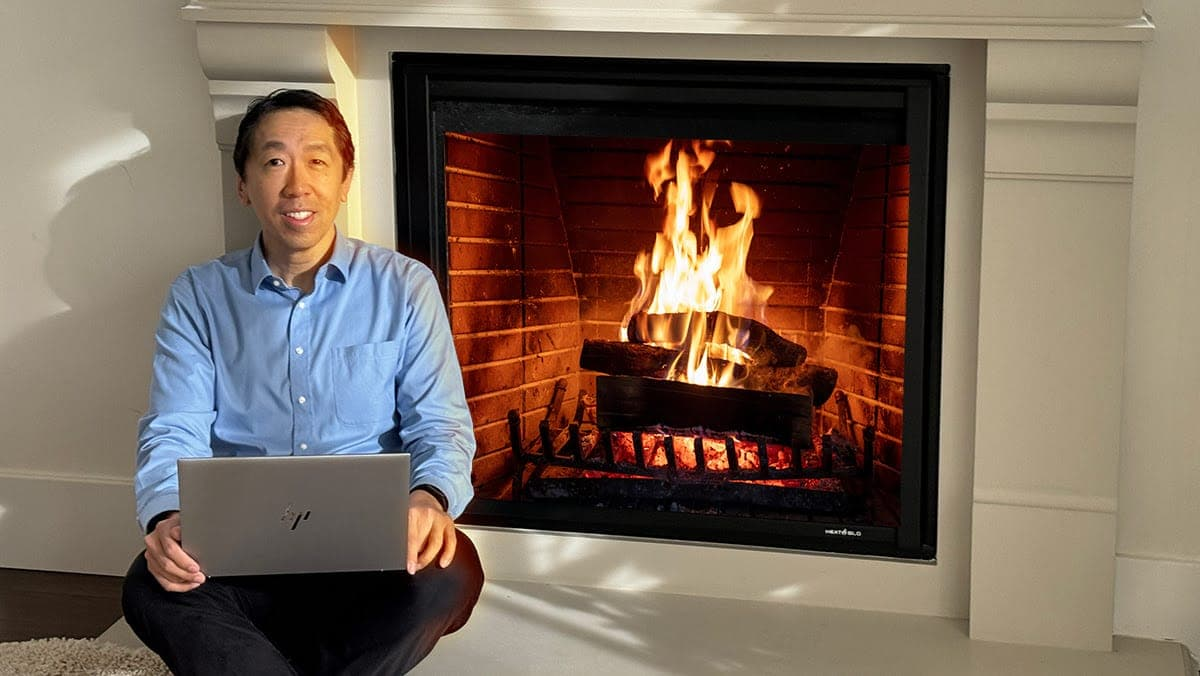

In [20]:
Image.open("unnamed--42-.jpg")

In [11]:
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:laion/CLIP-ViT-B-32-laion2B-s34B-b79K')
model.eval()
tokenizer = open_clip.get_tokenizer('hf-hub:laion/CLIP-ViT-B-32-laion2B-s34B-b79K')

image = preprocess_val(Image.open("unnamed--42-.jpg")).unsqueeze(0)
text = tokenizer(["a diagram", "a dog", "a cat"])

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print("Label probs:", text_probs)

Label probs: tensor([[0.9908, 0.0062, 0.0031]])


In [12]:
image = preprocess_val(Image.open("unnamed--42-.jpg")).unsqueeze(0)
text = tokenizer(["a photo of a man", "a photo of Andrew Ng", "a photo of a cat", "a photo of a human", "a diagram"])

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print("Label probs:", text_probs)  

Label probs: tensor([[1.2452e-01, 8.7302e-01, 3.6710e-06, 2.0128e-03, 4.4180e-04]])


In [13]:
image = preprocess_val(Image.open("unnamed--42-.jpg")).unsqueeze(0)
text = tokenizer(["Andrew Ng", "cat", "window"])

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print("Label probs:", text_probs)  

Label probs: tensor([[9.9972e-01, 2.2802e-04, 4.9266e-05]])
